# SHAP Tutorial

This Jupyter notebook goes through selected parts of the tutorial. The results will differ because of different train/test split, different explanation data, and very slightly different models.

The idea is the same, though.

The notebook uses the conda environment specified in "environment.yml".

## Load and inspect data

In [1]:
%load_ext lab_black

import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_parquet("rdata/df.parquet")
print("Shape of full data:", df.shape)
df.head()

Shape of full data: (1000000, 7)


,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0


In [3]:
df.describe()

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,2018.550270,0.600130,45.998782,1308.266530,124.981766,4.156266,0.089334
std,0.497467,0.489872,13.997827,285.505998,49.133293,3.545284,0.300652
min,2018.000000,0.000000,18.000000,950.000000,50.000000,0.000000,0.000000
25%,2018.000000,0.000000,35.000000,1090.000000,86.000000,1.000000,0.000000
50%,2019.000000,1.000000,45.000000,1240.000000,116.000000,3.000000,0.000000
75%,2019.000000,1.000000,56.000000,1460.000000,156.000000,6.000000,0.000000
max,2019.000000,1.000000,88.000000,3120.000000,341.000000,23.000000,4.000000


## Modeling

In this section, we split the data into 90% training and 10% test observations, and fit the three statistical models. Furthermore, we define the function that returns the true model values.

### Data split

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.1, random_state=30)
print("Shape of training data:", train.shape)
print("Shape of test data:", test.shape)

Shape of training data: (900000, 7)
Shape of test data: (100000, 7)


In [5]:
# Define response name and features names
y, x = df.columns[-1], list(df.columns[:-1])

print("The response name:", y)
print("The feature names:", x)

The response name: claim_nb
The feature names: ['year', 'town', 'driver_age', 'car_weight', 'car_power', 'car_age']


### Generalized linear model (GLM)

We use [Glum](https://glum.readthedocs.io/en/latest/), a high-performance implementation in Python.

In [6]:
from glum import GeneralizedLinearRegressor

glm_model = GeneralizedLinearRegressor(family="poisson", alpha=1e-6)
glm_model.fit(X=train[x], y=train[y])

print("Coefficients")
pd.Series(np.append(glm_model.intercept_, glm_model.coef_), index=["Intercept"] + x)

Coefficients


Intercept    -25.661383
year           0.011302
town           0.362117
driver_age    -0.004081
car_weight    -0.000046
car_power      0.004124
car_age       -0.022084
dtype: float64

### Deep neural net

We use TensorFlow to fit the deep neural net.

In [7]:
# Scale features to [-1, 1]
from sklearn.preprocessing import MinMaxScaler

nn_preprocessor = MinMaxScaler(feature_range=(-1, 1))
X_train = nn_preprocessor.fit_transform(train[x])

print("Test of the scaling function")
pd.DataFrame(X_train[0:5], columns=x)

Test of the scaling function


,year,town,driver_age,car_weight,car_power,car_age
0,-1.0,1.0,0.057143,-0.834101,-0.731959,-0.043478
1,-1.0,1.0,-0.828571,-0.889401,-0.512027,-0.391304
2,-1.0,1.0,-0.514286,-0.520737,-0.436426,-1.000000
3,-1.0,-1.0,0.485714,-0.861751,-0.876289,-0.826087
4,-1.0,-1.0,0.400000,-0.806452,-0.711340,-1.000000


In [8]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

cb = [EarlyStopping(patience=20), ReduceLROnPlateau(patience=5)]

# Architecture
inputs = keras.Input(shape=len(x))
z = layers.Dense(40, activation="tanh")(inputs)
z = layers.Dense(20, activation="tanh")(z)
z = layers.Dense(10, activation="tanh")(z)
outputs = layers.Dense(1, activation="exponential")(z)
nn_model = keras.Model(inputs=inputs, outputs=outputs)

nn_model.summary()

# Calculate gradients
nn_model.compile(optimizer=Adam(learning_rate=1e-4), loss="Poisson")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 dense (Dense)               (None, 40)                280       
                                                                 
 dense_1 (Dense)             (None, 20)                820       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [9]:
tf.random.set_seed(4349)

history = nn_model.fit(
    x=X_train,
    y=train[y],
    epochs=200,
    batch_size=10_000,
    validation_split=0.1,
    callbacks=cb,
    verbose=0,
)

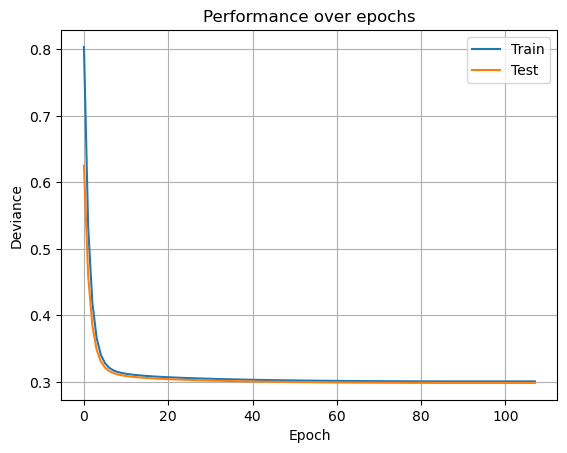

In [10]:
for data, label in zip(("loss", "val_loss"), ("Train", "Test")):
    plt.plot(history.history[data], label=label)
plt.legend()
plt.grid()
_ = plt.gca().set(title="Performance over epochs", xlabel="Epoch", ylabel="Deviance")

### LightGBM

To fit a boosted trees model, we use LightGBM.

In [11]:
import lightgbm as lgb

# Parameters (incl. nrounds) found by CV random search in script "tune_lgb_not_run.R"
params = dict(
    learning_rate=0.05,
    objective="poisson",
    metric="poisson",
    num_leaves=7,
    min_data_in_leaf=50,
    min_sum_hessian_in_leaf=0.001,
    colsample_bynode=0.8,
    bagging_fraction=0.8,
    lambda_l1=3,
    lambda_l2=5,
    num_threads=7,
)

lgb_model = lgb.train(
    params, train_set=lgb.Dataset(train[x], label=train[y]), num_boost_round=300
)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 542
[LightGBM] [Info] Number of data points in the train set: 900000, number of used features: 6
[LightGBM] [Info] Start training from score -2.414908


### True model

Since we use simulated data, the true underlying frequency model is known. We define the corresponding function.

In [12]:
def age_effect(age):
    x = (age - 66) / 60
    return 0.05 + x**8 + 0.4 * x**3 + 0.3 * x**2 + 0.06 * x


def true_model(X):
    """Returns pd.Series of true expected frequencies."""
    df = pd.DataFrame(X, columns=x)  # Needed because SHAP turns df to np.array
    log_lambda = (
        0.15 * df.town
        + np.log(age_effect(df.driver_age))
        + (0.3 + 0.15 * df.town) * df.car_power / 100
        - 0.02 * df.car_age
    )
    return np.exp(log_lambda)

In [13]:
# Test
true_model(df.head())

0    0.113245
1    0.167164
2    0.126912
3    0.052531
4    0.073640
dtype: float64

## SHAP analysis

Note again that we do not decompose the same rows as in the published tutorial (different random generator). The results will therefore differ, especially the waterfall plot.

### Select explanation data

In [14]:
X_explain = train[x].sample(n=1000, random_state=937)
print("Shape of X_explain:", X_explain.shape)

Shape of X_explain: (1000, 6)


### TreeSHAP

The "shap" package contains different interfaces. For our LightGBM model, we can use the newer and simpler one. The resulting "shap_lgb" object contains all info necessary in the plot functions.

In [15]:
import shap

lgb_explainer = shap.Explainer(lgb_model)
shap_lgb = lgb_explainer(X_explain)

#### Waterfall plot of first observation

Note again that we use a different row than in the tutorial.

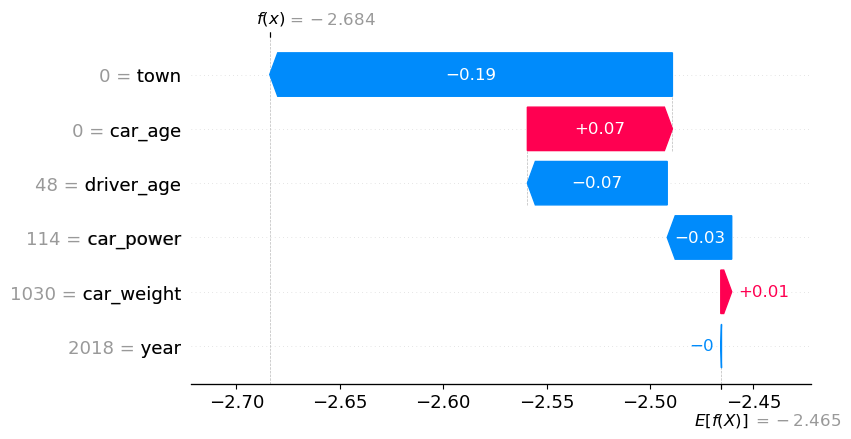

In [16]:
shap.plots.waterfall(shap_lgb[0])

#### SHAP importance

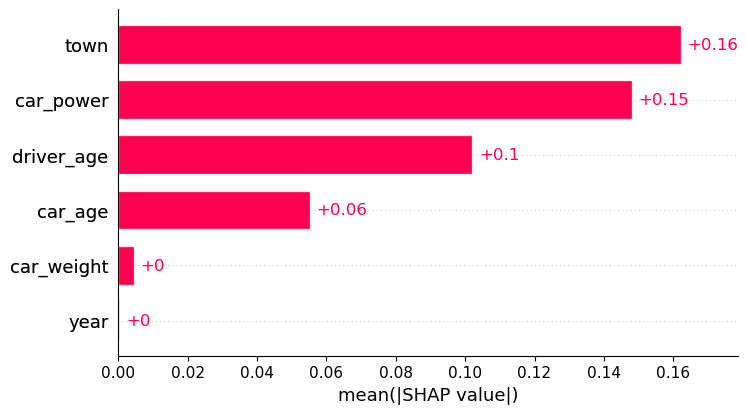

In [17]:
shap.plots.bar(shap_lgb)

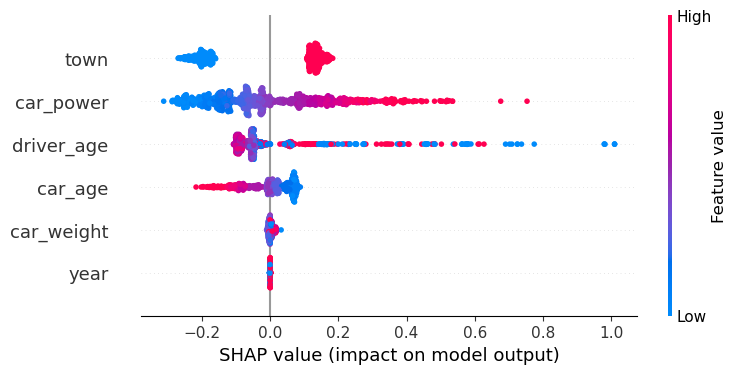

In [18]:
_ = shap.plots.beeswarm(shap_lgb)

#### SHAP dependence plots

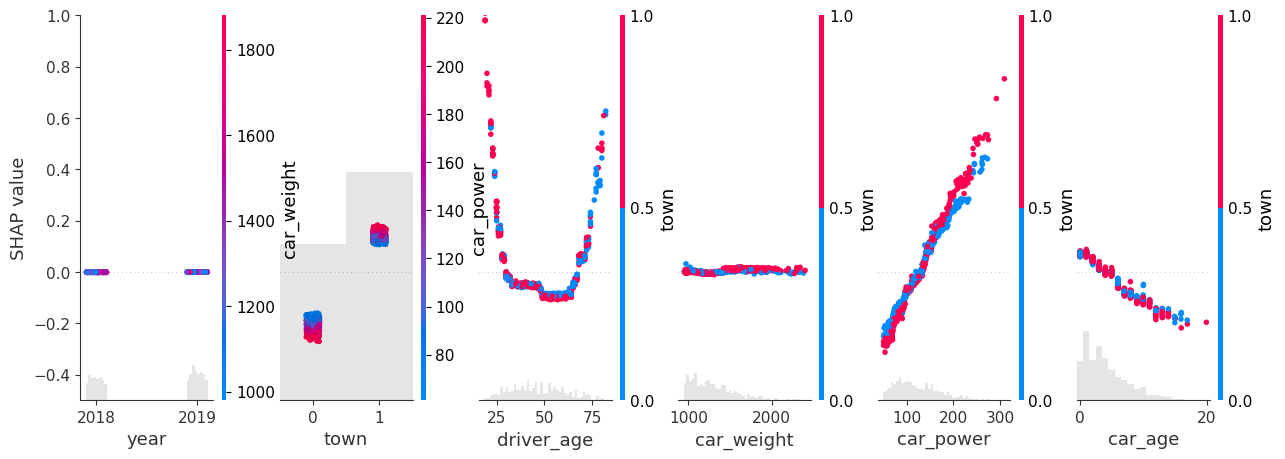

In [19]:
shap.plots.scatter(shap_lgb, color=shap_lgb, ymin=-0.5, ymax=1)

### GLM

Different explainers could be used to analyze the GLM. The fastest is the LinearExplainer, but we will use the model-agnostic KernelExplainer. The reason: a GLM can also contain interactions, so the LinearExplainer is not always possible.

In [20]:
# Background data (same for the GLM, the neural net, and the true model)
X_bg = train[x].sample(200, random_state=8366)

# How many subsets with 6 features?
nsamples = 2 ** len(x) - 2

# Crunching
glm_explainer = shap.KernelExplainer(lambda x: np.log(glm_model.predict(x)), data=X_bg)
shap_glm = glm_explainer.shap_values(X_explain, nsamples=nsamples)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1000/1000 [02:15<00:00,  7.36it/s]


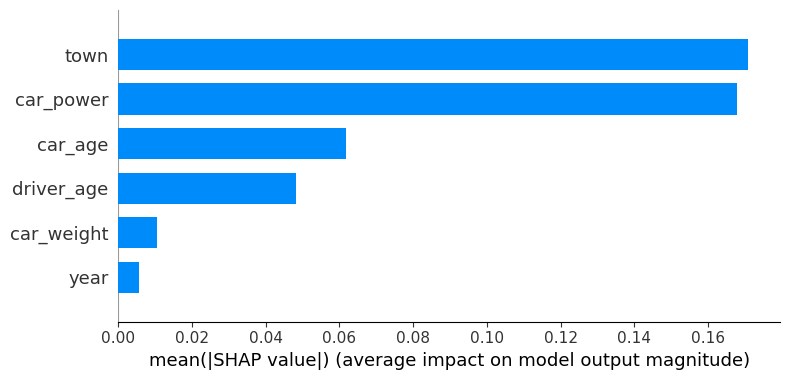

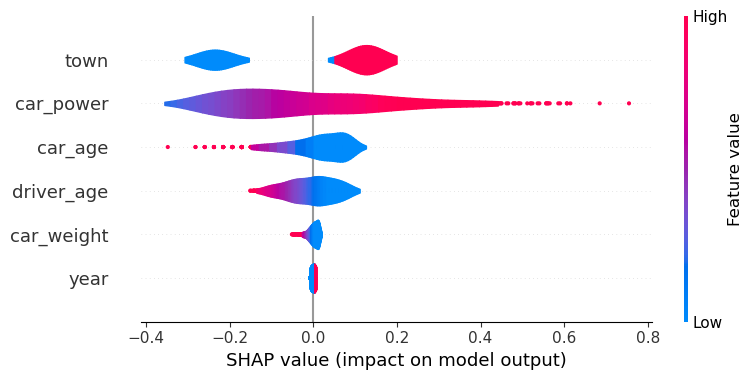

In [21]:
for t in ("bar", "violin"):
    shap.summary_plot(shap_glm, features=X_explain, plot_type=t, title=t)

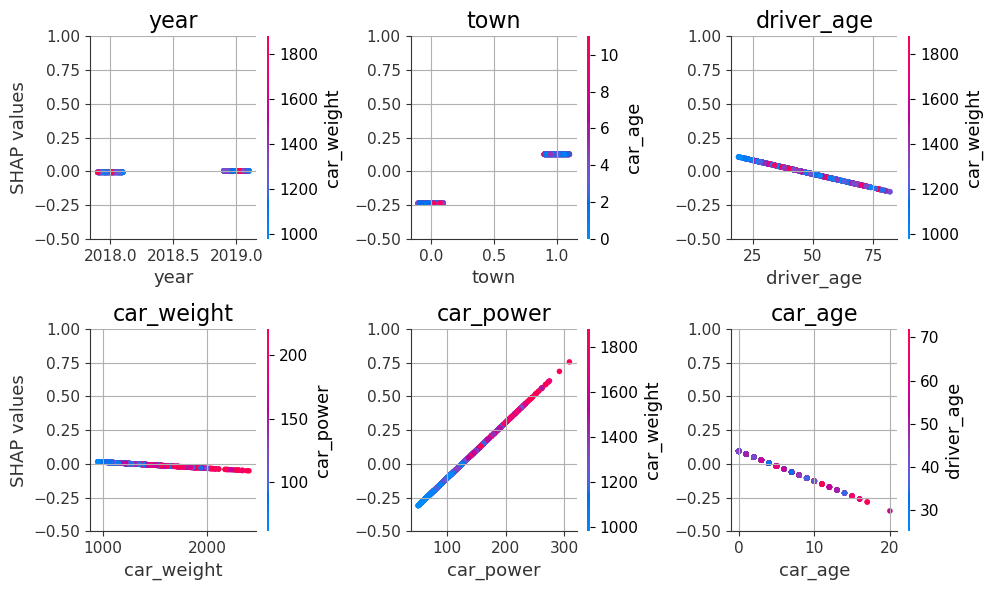

In [22]:
def all_dep_plots(x, shap_values, X):
    """Dependence plots for all features x."""
    fig, _ = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), sharey=True)

    for i, ax in enumerate(fig.axes):
        xvar = x[i]
        shap.dependence_plot(
            xvar,
            shap_values,
            features=X,
            x_jitter=0.2 * (xvar in ("town", "year")),
            ymin=-0.5,
            ymax=1,
            ax=ax,
            show=False,
        )
        ax.set_title(xvar, fontdict={"size": 16})
        ax.set_ylabel("SHAP values" if i % 3 == 0 else "")
        ax.grid()
    plt.tight_layout()


all_dep_plots(x, shap_glm, X_explain)

### Neural net

For the remaining models, we show only dependence plots.

In [23]:
def nn_predict(X):
    """Prediction function of the neural network (log scale)."""
    df = pd.DataFrame(X, columns=x)
    df_scaled = nn_preprocessor.transform(df)
    pred = nn_model.predict(df_scaled, verbose=0, batch_size=10_000).flatten()
    return np.log(pred)


nn_explainer = shap.KernelExplainer(nn_predict, data=X_bg)
shap_nn = nn_explainer.shap_values(X_explain, nsamples=nsamples)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1000/1000 [03:23<00:00,  4.93it/s]


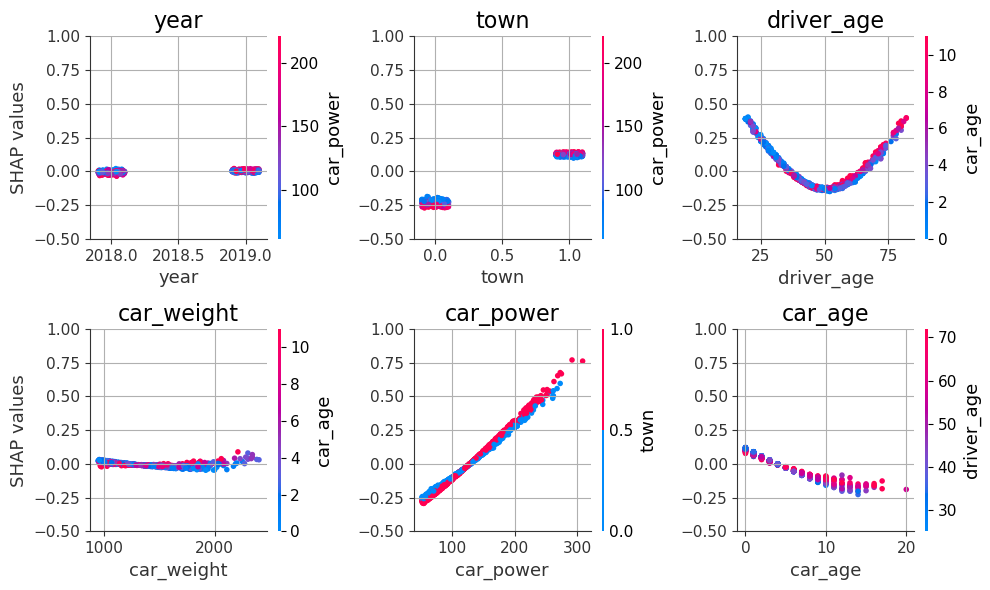

In [24]:
all_dep_plots(x, shap_nn, X_explain)

### True model

In [25]:
true_explainer = shap.KernelExplainer(lambda x: np.log(true_model(x)), data=X_bg)
shap_true = true_explainer.shap_values(X_explain, nsamples=nsamples)

Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 1000/1000 [01:32<00:00, 10.84it/s]


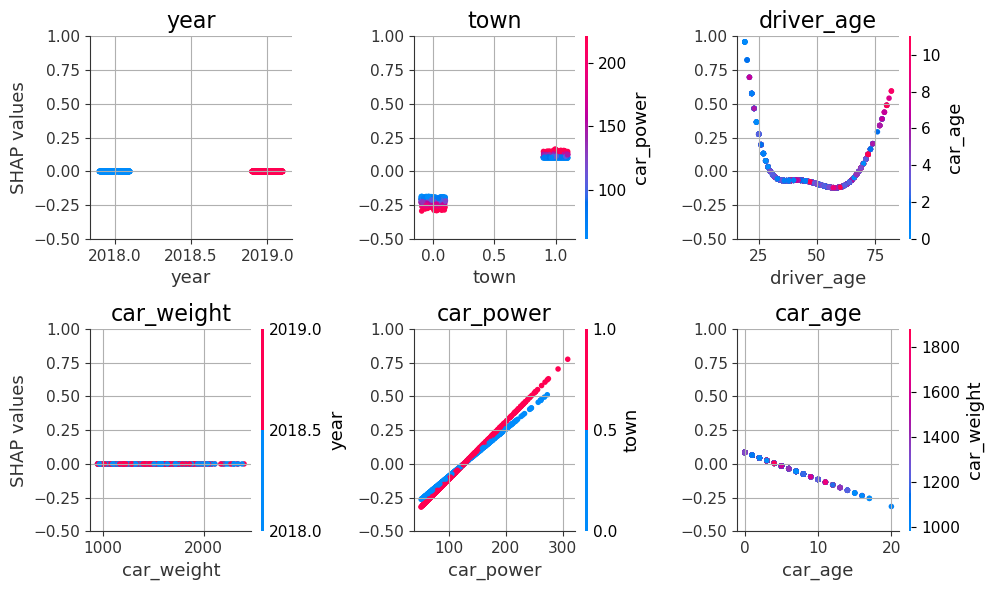

In [26]:
all_dep_plots(x, shap_true, X_explain)